# Track football players with YOLOv8 + ByteTrack 

ByteTrack is a multi object tracker that identifies and identifies the trajectory of objects with accuracy.

In this notebook we will track football players on the field from YOLOv8 predictions. The videos of this project can be found in this kaggle [DFL - Bundesliga Data Shootout](https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout/data) comptetition.

YOLOv8 was trained on [football-players-detection](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc) dataset from Roboflow .The weights can be found [here](https://drive.google.com/drive/folders/1-1r2psRgW7JRSEykRmvUYEY31ufuxiDb?usp=share_link)


Setup

In [ ]:
!pip install ultralytics --quiet 

In [ ]:
!git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -r requirements.txt
!cd ByteTrack && python3 setup.py develop
!pip install cython_bbox --quiet 

In [4]:
!pip install onemetric --quiet 

In [5]:
import sys
sys.path.append("ByteTrack")

In [6]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2

In [9]:
path_project = Path("drive/MyDrive/Projects/track-football-players/")

## Load the video

In [10]:
def get_video_frames(video_path):

    video = cv2.VideoCapture(str(video_path))

    frames = []
    while video.isOpened():
        success, frame = video.read()
        if not success:
            break
        frames.append(frame)

    video.release()

    return frames

In [11]:
video_path = path_project/ "clips/0bfacc_7.mp4"

In [12]:
frames = get_video_frames(video_path)

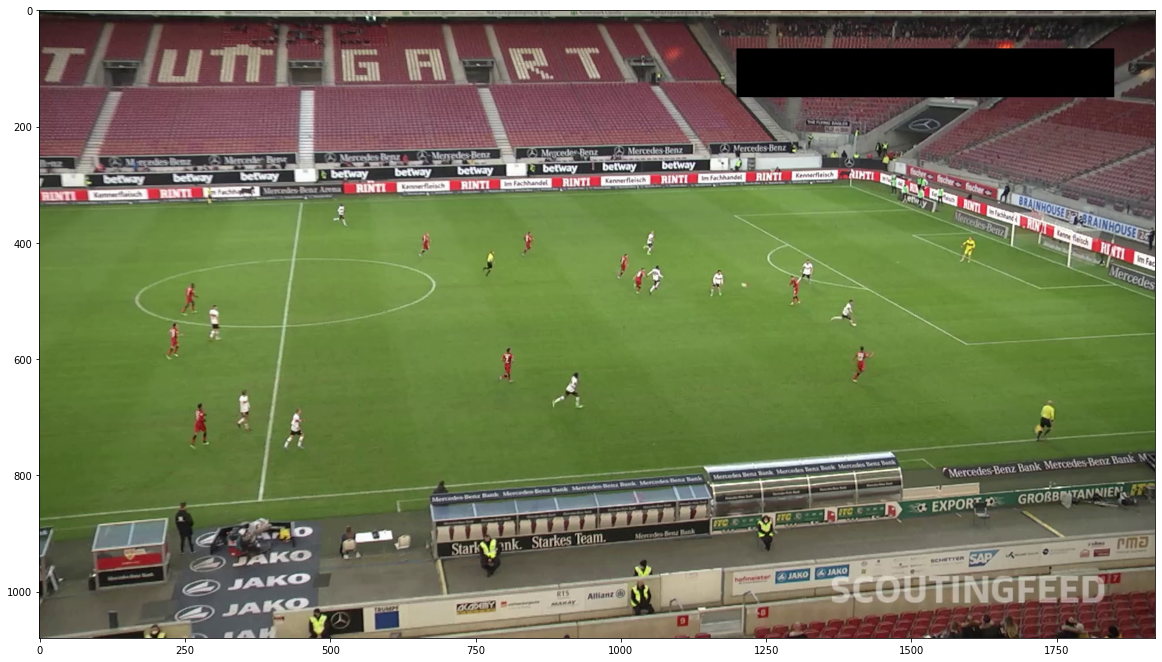

In [13]:
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
plt.show()

## Load YOLOv8

In [14]:
path_weights = path_project/ "yolov8-weights/yolov8l-football-players.pt"

In [15]:
yolo_model = YOLO(path_weights)

ind_to_cls = {
    0: "ball",
    1 : "goalkeeper",
    2 : "player",
    3 : "referee"
}

colors = {
    "ball": (0,200,200),
    "player": (255,0,0),
    "goalkeeper":(255,0,255),
    "referee": (0,0,255),
}

Display predictions on the first frame

In [16]:
prediction = yolo_model(frames[0])

Ultralytics YOLOv8.0.26 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
Model summary (fused): 268 layers, 43609692 parameters, 0 gradients, 164.8 GFLOPs

0: 384x640 1 goalkeeper, 20 players, 2 referees, 55.6ms
Speed: 1.0ms pre-process, 55.6ms inference, 25.8ms postprocess per image at shape (1, 3, 640, 640)


In [17]:
def draw_detections(image, detections, draw_tacker_id: bool = False):
  image = image.copy()
  for pred in detections:
    bbox = pred.boxes.xyxy.int().tolist()[0]
    cls_ind = pred.boxes.cls.int().item()
    cls = ind_to_cls[cls_ind]
    cv2.rectangle(img=image, pt1=tuple(bbox[:2]), pt2=tuple(bbox[2:]), color=colors[cls], thickness=3)
    if draw_tacker_id:
      cv2.putText(image, str(pred.tracker_id), (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, colors[cls], 3)
    else:
      cv2.putText(image, cls, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, colors[cls], 3)

  return image

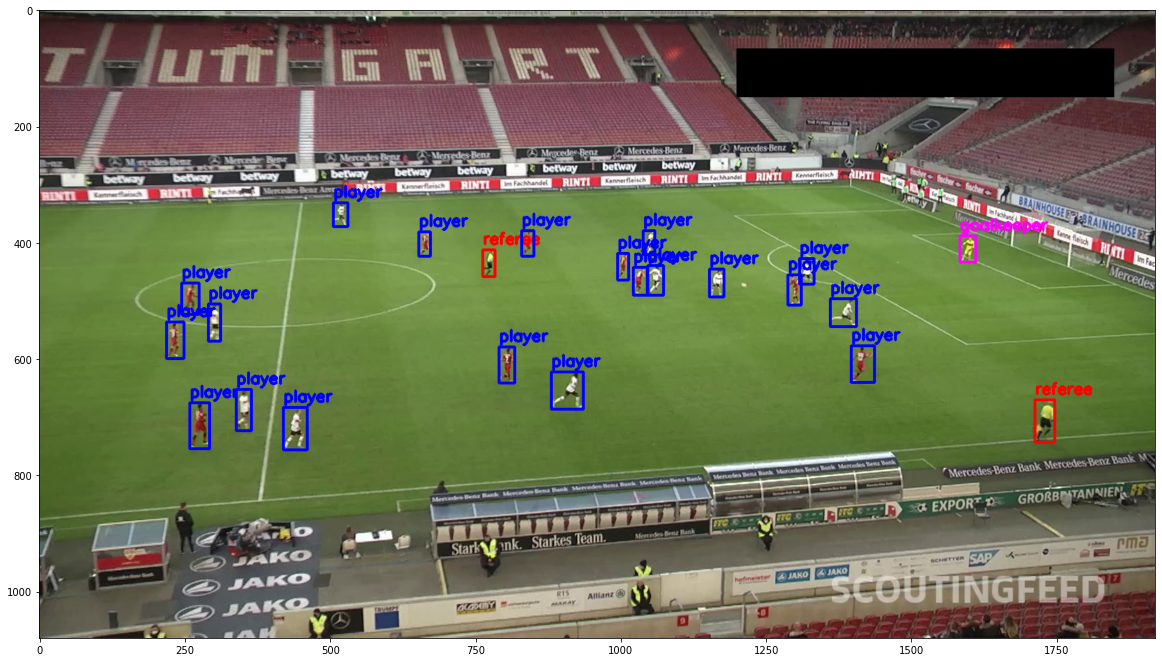

In [18]:
image = draw_detections(frames[0], prediction[0])

plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.grid(False)
plt.show()

## Create ByteTracker

ByteTrack creates trackers that are identified and attempts to find their trajectory across the frames.  
Also it expects the detection to have this format: (x1, y1, x2, y2, conf).

So we need to convert yolo detections to ByteTrack format and also identify they correspond to which tracker that is followed by ByteTrack.

In [25]:
from dataclasses import dataclass

@dataclass(frozen=True)
class BYTETrackerArgs:
  track_thresh: float = 0.25
  track_buffer: int = 30
  match_thresh: float = 0.8
  aspect_ratio_thresh: float = 3.0
  min_box_area: float = 1.0
  mot20: bool = False

In [26]:
# initiate tracker
byte_tracker = BYTETracker(BYTETrackerArgs)

In [27]:
def format_predictions(predictions, with_conf: bool = True):
  """
  Format yolo detection to ByteTracke format: (x1, y1, x2, y2, conf)
  """
  frame_detections = []
  for pred in predictions:
      bbox = pred.boxes.xyxy.int().tolist()[0]
      conf = pred.boxes.conf.item()
      if with_conf:
        detection = bbox + [conf]
      else:
        detection = bbox

      frame_detections.append(detection)
  return np.array(frame_detections, dtype=float)


In [31]:
def match_detections_with_tracks(detections, tracks):
  """
  Find which tracker corresponds to yolo detections and set the tracker_id.
  We compute the iou between the detection and trackers.
  """
  detections_bboxes = format_predictions(detections, with_conf=False)
  tracks_bboxes = np.array([track.tlbr for track in tracks], dtype=float)
  iou = box_iou_batch(tracks_bboxes, detections_bboxes)
  track2detection = np.argmax(iou, axis=1)

  for tracker_index, detection_index in enumerate(track2detection):
    if iou[tracker_index, detection_index] != 0:
      detections[detection_index].tracker_id = tracks[tracker_index].track_id
  return detections

In [29]:
def get_video_writer(output_video_path, fps, width, height):
  """
  Create a video writer to save new frames after annotation
  """
  output_video_path.parent.mkdir(exist_ok=True)
  return cv2.VideoWriter(
      str(output_video_path),
      fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
      fps=fps,
      frameSize=(width, height),
      isColor=True
  )

## Track players and save to video

In [ ]:
output_video_path = path_project/ ("tracking/tracked_yolov8l_640_" + video_path.stem + ".mp4")

video_writer = get_video_writer(
    output_video_path,
    30,
    1920,
    1080
)

In [30]:
for frame in tqdm(frames):

    # detect players with yolo
    detections = yolo_model(frame, verbose=0)[0]

    # create a new list of detection with tracker_id attribute.
    detections_with_tracker = []
    for detection in detections:
      detection.tracker_id = ""
      detections_with_tracker.append(detection)

    # get trackers with ByteTrack
    tracks = byte_tracker.update(
        output_results=format_predictions(detections_with_tracker, with_conf=True),
        img_info=frame.shape,
        img_size=frame.shape
    )

    # set tracker_id in yolo detections
    detections_with_tracker = match_detections_with_tracks(detections_with_tracker, tracks)

    # annotate the frame
    image = draw_detections(frame, detections_with_tracker, True)

    # save the frame to video writer
    video_writer.write(image)

# save the video
video_writer.release()

drive/MyDrive/Projects/track-football-players/tracking/tracked_0bfacc_7.mp4


100%|██████████| 750/750 [00:54<00:00, 13.82it/s]
